# Imports

In [1]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
name_db = pd.read_csv('firstname_with_sex.csv', sep=';')
transcript_db = pd.read_csv('transcriptions_with_sex.csv')

In [3]:
name_db.head()

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


In [4]:
transcript_db.head()

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme


# Descriptive statistics on the datasets 

**Firstname Dataset**

In [5]:
name_db.shape

(6946, 3)

In [6]:
# NaN values
name_db.isna().sum()

firstname    0
male         0
female       0
dtype: int64

In [7]:
# Most common names in the transcript
name_db.set_index('firstname').idxmax()

male       jean
female    marie
dtype: object

In [8]:
# Least common names in the transcript
name_db.set_index('firstname').idxmin()

male      noëlle
female    geraud
dtype: object

In [9]:
# Add the probability of a name being associated to a male or a female
name_db['male_prob'] = name_db['male'] / (name_db['male'] + name_db['female'])

name_db['female_prob'] = 1 - name_db['male_prob']


In [10]:
threshold = 0.6

male_names = name_db[name_db['male_prob'] > threshold].shape[0]
female_names = name_db[name_db['female_prob'] > threshold].shape[0]
unisex = name_db[(name_db['male_prob'] <= threshold) & (name_db['female_prob'] <= threshold)].shape[0]

print(f"Number of firstnames mostly associated with the male gender : {male_names}")
print(f"Number of firstnames mostly associated with the female gender : {female_names}")
print(f"Number of firstnames most likely unisex : {unisex}")

Number of firstnames mostly associated with the male gender : 3378
Number of firstnames mostly associated with the female gender : 3480
Number of firstnames most likely unisex : 88


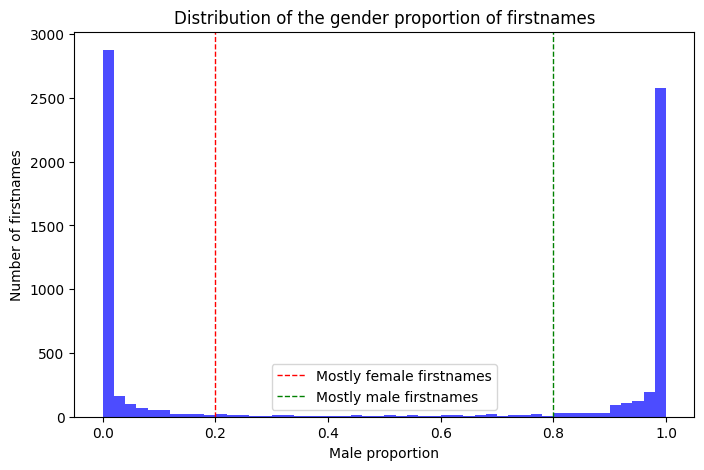

In [11]:
# Distribution of the gender proportion of firstnames

plt.figure(figsize=(8, 5))
plt.hist(name_db['male_prob'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of the gender proportion of firstnames')
plt.xlabel('Male proportion')
plt.ylabel('Number of firstnames')

plt.axvline(x=0.2, color='r', linestyle='--', linewidth=1, label='Mostly female firstnames')
plt.axvline(x=0.8, color='g', linestyle='--', linewidth=1, label='Mostly male firstnames')

plt.legend()
plt.show()

**Transcriptions with sex Dataset**

In [12]:
transcript_db.shape

(241, 4)

In [13]:
# NaN values
transcript_db.isna().sum()

subject_line    0
groundtruth     0
prediction      0
sex             0
dtype: int64

Most of the information is contained in the groundtruth and prediction columns and stored as strings

In [14]:
print(transcript_db['groundtruth'][0])

print(transcript_db['prediction'][0])

surname: Chardon firstname: Marie occupation: idem link: fille age: 30 
nom: Chardon prénom: Marie date_naissance: 30 lieux_naissance: " 


Let's extract the information contained in these columns and extract them in other columns

In [15]:
# We first find all the categories displayed in the columns groundtruth and prediction

def extract_categories(text):
    # Find all the words followed by ':'
    return re.findall(r'\b(\w+):', text)

In [16]:
# Apply the extracting function to the groundtruth and prediction columns
cat_groundtruth = transcript_db['groundtruth'].apply(extract_categories)
cat_prediction = transcript_db['prediction'].apply(extract_categories)

# We get a list of the categories for all lines in the dataset
print(cat_groundtruth[:2])
print(cat_prediction[:2])

0    [surname, firstname, occupation, link, age]
1    [surname, firstname, occupation, link, age]
Name: groundtruth, dtype: object
0       [nom, prénom, date_naissance, lieux_naissance]
1    [nom, prénom, date_naissance, lieux_naissance,...
Name: prediction, dtype: object


In [17]:
# We get the list of the unique categories for each column

all_cat_groundtruth = set(cat for sublist in cat_groundtruth for cat in sublist)
all_cat_prediction = set(cat for sublist in cat_prediction for cat in sublist)

print(all_cat_groundtruth)
print(all_cat_prediction)

{'age', 'lob', 'occupation', 'observation', 'birth_date', 'link', 'firstname', 'surname', 'civil_status', 'employer'}
{'nom', 'lieux_naissance', 'profession', 'date_naissance', 'état_civil', 'relation', 'employeur', 'éducation', 'prénom'}


In [18]:
# Dictionaries that map each field in the string with its associated Regex expression

groundtruth_dict = {
    'groundtruth_surname': 'surname: ([^\s]+)',
    'groundtruth_firstname': 'firstname: ([^\s]+)',
    'groundtruth_occupation': 'occupation: ([^\s]+)',
    'groundtruth_lob': 'lob: ([^\s]+)',
    'groundtruth_observation': 'observation: ([^\s]+)',
    'groundtruth_birth_date': 'birth_date: ([^\s]+)',
    'groundtruth_civil_status': 'civil_status: ([^\s]+)',
    'groundtruth_employer': 'employer: ([^\s]+)',
    'groundtruth_link': 'link: ([^\s]+)',
    'groundtruth_age': 'age: ([^\s]+)'
}

pred_dict = {
    'prediction_surname': 'nom: ([^\s]+)',
    'prediction_firstname': 'prénom: ([^\s]+)',
    'prediction_profession': 'profession: ([^\s]+)',
    'prediction_relation': 'relation: ([^\s]+)',
    'prediction_education': 'éducation: ([^\s]+)',
    'prediction_civil_status': 'état_civil: ([^\s]+)',
    'prediction_age': 'date_naissance: ([^\s]+)',
    'prediction_place_of_birth': 'lieux_naissance: ([^\s]+)',
    'prediction_employer': 'employeur: ([^\s]+)'
}

In [19]:
# Create empty columns that will be used to store the data after Regex operations
for col in list(groundtruth_dict.keys()) + list(pred_dict.keys()) : 
    transcript_db[col] = ""

# Extraction et stockage des informations
for key, pattern in groundtruth_dict.items():
    transcript_db[key] = transcript_db['groundtruth'].apply(lambda x: re.search(pattern, x).group(1) if re.search(pattern, x) else "")

for key, pattern in pred_dict.items():
    transcript_db[key] = transcript_db['prediction'].apply(lambda x: re.search(pattern, x).group(1) if re.search(pattern, x) else "")

In [20]:
transcript_db.head()

,subject_line,groundtruth,prediction,sex,groundtruth_surname,groundtruth_firstname,groundtruth_occupation,groundtruth_lob,groundtruth_observation,groundtruth_birth_date,...,groundtruth_age,prediction_surname,prediction_firstname,prediction_profession,prediction_relation,prediction_education,prediction_civil_status,prediction_age,prediction_place_of_birth,prediction_employer
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,Chardon,Marie,idem,,,,...,30,Chardon,Marie,,,,,30,"""",
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,Lhopital,Louis-Jean,sp,,,,...,67,Lhopital,Louis,,,,,67,Sn,ahef
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,Papin,Marie,idem,,,,...,15,Pyrin,Marie,,d,,,55,,
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,Lavocat,Marie,,Rigny,,1875,...,,Lavocat,Marie,'',,,,1875,Rigny,
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,Benne,Marguerite,,,,,...,78,Benne,Marguerite,,'',,,78,id,


Not all the information contained in the DataFrame above will be useful to predict the sex

However, the columns containing information on the profession and the link in the family are useful to predict the sex

In [21]:
print('The column groundtruth_occupation has ', (transcript_db.groundtruth_occupation == "").sum(), ' missing values')
print('The column groundtruth_link has ', (transcript_db.groundtruth_link == "").sum(), ' missing values')

print('\n')

print('The column prediction_profession has ', (transcript_db.prediction_profession == "").sum(), ' missing values')
print('The column prediction_relation has ', (transcript_db.prediction_relation == "").sum(), ' missing values')

The column groundtruth_occupation has  42  missing values
The column groundtruth_link has  11  missing values


The column prediction_profession has  174  missing values
The column prediction_relation has  80  missing values


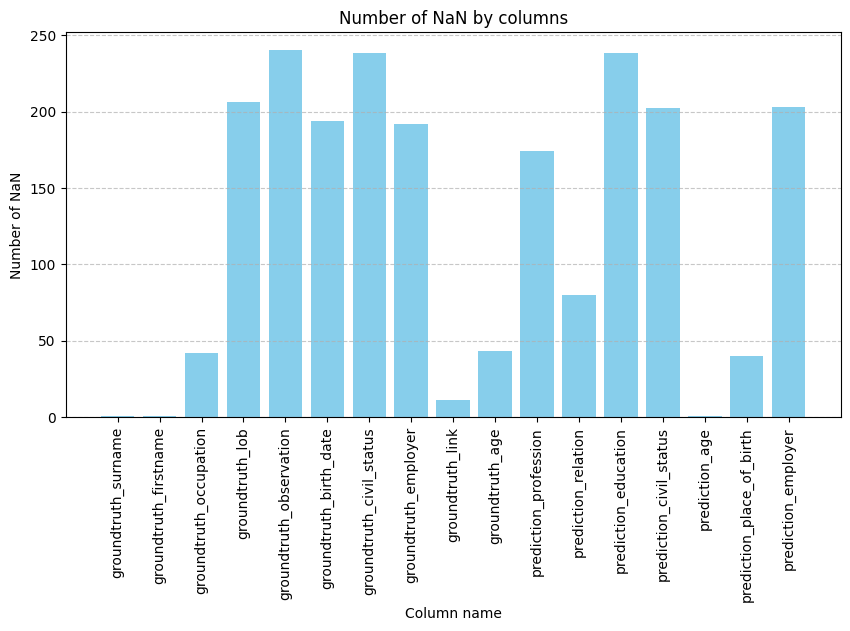

In [22]:
empty_counts = {}

for col in transcript_db.columns:
    empty_count = transcript_db[col].eq("").sum()
    empty_counts[col] = empty_count

empty_counts_df = pd.DataFrame.from_dict(empty_counts, orient='index', columns=['Number of NaN'])
empty_counts_df = empty_counts_df[empty_counts_df['Number of NaN'] != 0]

plt.figure(figsize=(10, 5))
plt.bar(empty_counts_df.index, empty_counts_df['Number of NaN'], align='center', color='skyblue')

plt.title('Number of NaN by columns')
plt.xlabel('Column name')
plt.ylabel('Number of NaN')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Considering the high number of missing values in the ```prediction_profession``` and ```prediction_relation``` columns, it is more likely that we will use a model on the groundtruth columns

Now let's normalize the data contained in the ```groundtruth_occupation``` and ```groundtruth_link``` columns

In [23]:
print(dict(transcript_db.groundtruth_occupation.str.lower().value_counts()))
print(dict(transcript_db.groundtruth_link.str.lower().value_counts()))

{'idem': 54, '': 42, 'néant': 15, 'sans': 15, 'cultivateur': 14, 'sp': 10, 'domestique': 10, 's.p': 10, 'métayer': 6, 'manoeuvre': 5, 'journalier': 4, 's.p.': 3, 'cult': 3, 's': 3, 'garde': 2, 'propriétaire': 2, 'ouvrier': 2, 'forgeron': 2, 'employé': 2, 'cantonnier': 1, 'journalière': 1, 'argentière': 1, 'couvreur': 1, 'roulier': 1, 'jardinier': 1, 'voiturier': 1, 'femme': 1, 'garde-champêtre': 1, 'buraliste': 1, 'clerc': 1, 'culivateur': 1, 'boulanger': 1, 'charcutier': 1, 'quincaillier': 1, 'sellier': 1, 'imprimeur': 1, 'cullotière': 1, 'patissier': 1, 'blanchiseuse': 1, 'nourrisson': 1, 'cultivatrice': 1, 'cultivat': 1, 'charretier': 1, 'rentière': 1, 'repasseuse': 1, 'receveur': 1, 'domest.': 1, 'menuisier': 1, 'tourneur': 1, 'agent': 1, 'couturière': 1, 'déposit': 1, 'tisserand': 1, 'employée': 1, 'coiffeur': 1, 'cultiv': 1}
{'chef': 56, 'idem': 29, 'enfant': 23, 'femme': 20, 'fils': 19, 'épouse': 16, 'fille': 13, '': 11, 'sa': 7, 'leur': 7, 'domestique': 6, 'mère': 4, 'son': 3, 

In [50]:
# Standardize the variable 'groundtruth_occupation'
transcript_db['groundtruth_occupation'] = transcript_db['groundtruth_occupation'].str.replace('néant','') \
                                                                   .replace(['s', 'sp', 's.p', 's.p.'],  'sans profession') \
                                                                   .replace('sans', 'sans profession') \
                                                                   .replace(['culivateur', 'cult', 'cultivat', 'cultiv'], 'cultivateur') \
                                                                   .replace('domest.', 'domestique') \
                                                                   .replace('déposit', '') \
                                                                   .replace('idem', '') 


# Standardize the variable 'groundtruth_link'
transcript_db['groundtruth_link'] = transcript_db['groundtruth_link'].str.replace('ch.', 'chef') \
                                                       .replace('ép', "épouse") \
                                                       .replace('bru', 'belle-fille') \
                                                       .replace('enf', 'enfant') \
                                                       .replace('leur', '') \
                                                       .replace('schouer', '') \
                                                       .replace('idem', '') \
                                                       .replace('domest.', 'domestique')                                      
                                    


In [51]:
print(dict(transcript_db.groundtruth_occupation.str.lower().value_counts()))
print(dict(transcript_db.groundtruth_link.str.lower().value_counts()))

{'': 112, 'sans profession': 40, 'cultivateur': 20, 'domestique': 11, 'métayer': 6, 'manoeuvre': 5, 'journalier': 4, 'forgeron': 2, 'garde': 2, 'propriétaire': 2, 'employé': 2, 'ouvrier': 2, 'cantonnier': 1, 'journalière': 1, 'roulier': 1, 'couvreur': 1, 'argentière': 1, 'jardinier': 1, 'femme': 1, 'garde-champêtre': 1, 'voiturier': 1, 'buraliste': 1, 'clerc': 1, 'quincaillier': 1, 'charcutier': 1, 'sellier': 1, 'sans': 1, 'imprimeur': 1, 'boulanger': 1, 'patissier': 1, 'cullotière': 1, 'blanchiseuse': 1, 'nourrisson': 1, 'cultivatrice': 1, 'charretier': 1, 'rentière': 1, 'repasseuse': 1, 'receveur': 1, 'menuisier': 1, 'tourneur': 1, 'agent': 1, 'couturière': 1, 'tisserand': 1, 'employée': 1, 'coiffeur': 1}
{'chef': 59, '': 46, 'enfant': 24, 'femme': 20, 'fils': 19, 'épouse': 19, 'fille': 13, 'sa': 7, 'domestique': 7, 'mère': 4, 'belle-mère': 3, 'son': 3, 'belle-fille': 3, 'père': 2, 'petit-fils': 2, 'frère': 2, 'assisté': 2, 'leur': 1, 'petite-fille': 1, 'mére': 1, 'pensionnaire': 1, 

# First baseline model using the name dataset

We create a naive baseline model that will use the name dataset to infer if a new name is associated with male or female

In [26]:
# Dictionary with the male probability associated with each name in the name dataset
prob_male_dict = dict(zip(name_db['firstname'].str.capitalize(), round(name_db['male_prob'], 3)))

prob_male_dict

{'Marie': 0.004,
 'Jean': 0.997,
 'Pierre': 0.997,
 'Jeanne': 0.002,
 'François': 0.995,
 'Joseph': 0.995,
 'Anne': 0.002,
 'Marguerite': 0.002,
 'Catherine': 0.002,
 'Louis': 0.996,
 'Françoise': 0.002,
 'Jacques': 0.997,
 'Antoine': 0.996,
 'Nicolas': 0.996,
 'Louise': 0.002,
 'Claude': 0.985,
 'Charles': 0.996,
 'Elisabeth': 0.002,
 'Madeleine': 0.002,
 'Michel': 0.996,
 'Etienne': 0.996,
 'Guillaume': 0.996,
 'Claudine': 0.002,
 'André': 0.996,
 'Yves': 0.997,
 'Henri': 0.997,
 'Antoinette': 0.002,
 'Julien': 0.996,
 'René': 0.996,
 'Rose': 0.003,
 'Rosalie': 0.002,
 'Auguste': 0.996,
 'Georges': 0.996,
 'Joséphine': 0.002,
 'Thérèse': 0.002,
 'Marianne': 0.002,
 'Barbe': 0.003,
 'Paul': 0.997,
 'Augustin': 0.996,
 'Jules': 0.996,
 'Mathurin': 0.996,
 'Suzanne': 0.002,
 'Alexandre': 0.995,
 'Julie': 0.002,
 'Laurent': 0.996,
 'Victor': 0.996,
 'Perrine': 0.001,
 'Eugène': 0.994,
 'Victoire': 0.003,
 'Dominique': 0.932,
 'Philippe': 0.972,
 'Gabriel': 0.993,
 'Julienne': 0.002,
 'Lé

In [27]:
# We create a function that predict a name's genre based on the male probability
def predict_sex(name):
    if name in prob_male_dict:
        prob = prob_male_dict.get(name, 0.5)
        return 'homme' if prob > 0.5 else 'femme'
    else:
        return 'inconnu'

In [28]:
# We then apply the function on the transcript dataset to calculate a baseline prediction
transcript_db['baseline_pred_sex'] = transcript_db['groundtruth_firstname'].apply(predict_sex)

transcript_db['baseline_pred_sex'].value_counts(normalize=True)

baseline_pred_sex
homme      0.502075
femme      0.460581
inconnu    0.037344
Name: proportion, dtype: float64

In [29]:
def compute_accuracy(df, col1, col2, model_name):
    
    TP = len(df[df[col1] == df[col2]])

    accuracy = TP / len(df)
    print(f'The accuracy of the {model_name} model is', round(accuracy*100, 2), '%')

In [30]:
compute_accuracy(transcript_db, 'sex', 'baseline_pred_sex', 'baseline')

The accuracy of the baseline model is 92.12 %


# Training a Classifier

**Naïve Bayes Classifier**

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [32]:
name_db['sex_infered'] = name_db['firstname'].str.capitalize().apply(predict_sex)

X = name_db['firstname']
y = name_db['sex_infered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [33]:
NB_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
        ])

NB_clf.fit(X_train, y_train)
NB_clf.score(X_test, y_test)

0.4928023032629559

In [34]:
transcript_db['NB_predict'] = NB_clf.predict(transcript_db['groundtruth_firstname'])

compute_accuracy(transcript_db, 'sex', 'NB_predict', 'naïve Bayes')

The accuracy of the naïve Bayes model is 78.01 %


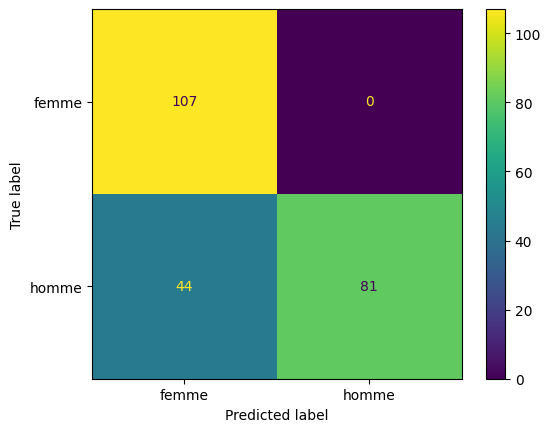

In [35]:
cm = confusion_matrix(transcript_db['sex'], transcript_db['NB_predict'], labels=NB_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=NB_clf.classes_)

disp.plot()
plt.show()

*Error analysis*

In [53]:
transcript_db[transcript_db['NB_predict'] != transcript_db['sex']][['sex', 'NB_predict']]

,sex,NB_predict
5,homme,femme
6,homme,femme
7,homme,femme
17,ambigu,femme
18,homme,femme
21,homme,femme
24,homme,femme
26,homme,femme
29,homme,femme
36,homme,femme


**Decision Tree Classifier**

In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
DT_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier(random_state=0))
                ])

DT_clf.fit(X_train, y_train)
DT_clf.score(X_test, y_test)

0.508637236084453

In [38]:
transcript_db['DT_predict'] = DT_clf.predict(transcript_db['groundtruth_firstname'])

compute_accuracy(transcript_db, 'sex', 'DT_predict', 'Decision Tree Classifier')

The accuracy of the Decision Tree Classifier model is 86.72 %


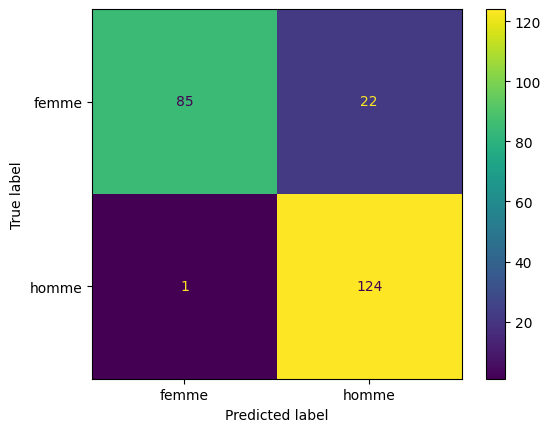

In [39]:
cm = confusion_matrix(transcript_db['sex'], transcript_db['DT_predict'], labels=DT_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=DT_clf.classes_)

disp.plot()
plt.show()

*Error analysis*

In [56]:
transcript_db[transcript_db['DT_predict'] != transcript_db['sex']][['sex', 'DT_predict']]

,sex,DT_predict
8,femme,homme
12,femme,homme
17,ambigu,homme
27,femme,homme
39,femme,homme
40,femme,homme
41,femme,homme
42,femme,homme
57,femme,homme
59,ambigu,femme


# Pre-trained models

In [40]:
from transformers import pipeline

/home/onyxia/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")


In [42]:
for idx, row in transcript_db.iterrows() : 

    prompt = f"Je m'appelle {row.groundtruth_firstname}. Je suis {row.groundtruth_occupation}. J'ai le statut de {row.groundtruth_link} dans ma famille."

    res = classifier(prompt, candidate_labels = ["femme", "homme"])

    transcript_db.loc[idx, "BART_predict"] = res.get('labels')[0]

In [43]:
compute_accuracy(transcript_db, 'sex', 'BART_predict', 'Zero Shot Classifier')

The accuracy of the Zero Shot Classifier model is 94.61 %


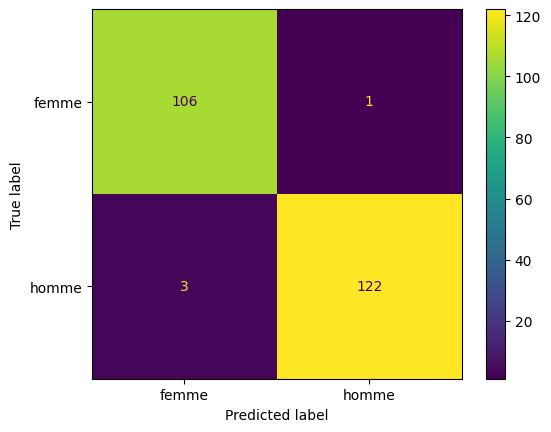

In [44]:
cm = confusion_matrix(transcript_db['sex'], transcript_db['BART_predict'], labels=DT_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=DT_clf.classes_)

disp.plot()
plt.show()

*Error analysis*

In [57]:
transcript_db[transcript_db['BART_predict'] != transcript_db['sex']][['sex', 'BART_predict']]

,sex,BART_predict
17,ambigu,homme
59,ambigu,femme
76,homme,femme
94,ambigu,homme
123,ambigu,femme
124,ambigu,femme
130,ambigu,femme
146,homme,femme
155,homme,femme
196,ambigu,homme
